In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from time import time

import torch
import torch.optim as optim
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
import torch.distributions as TD

import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm

# in order to install: pip install POT
import ot

import sys
sys.path.append('../../homeworks') # to grab dgm_utils from ../../homeworks directory
from tqdm.notebook import tqdm

if torch.cuda.is_available():
    DEVICE = 'cuda'
    GPU_DEVICE = 3
    torch.cuda.set_device(GPU_DEVICE)
else:
    DEVICE='cpu'
# DEVICE='cpu'

import warnings
warnings.filterwarnings('ignore')

# dgm_utils
from dgm_utils import train_model, show_samples, visualize_images
from dgm_utils import visualize_2d_samples, visualize_2d_densities, visualize_2d_data

def reset_seed():
    OUTPUT_SEED = 0xBADBEEF
    torch.manual_seed(OUTPUT_SEED)
    np.random.seed(OUTPUT_SEED)

reset_seed()

# <center>Deep Generative Models</center>
## <center>Seminar 10</center>

<center><img src="pics/AIMastersLogo.png" width=600 /></center>
<center>14.11.2022</center>


## Plan

1. $1$-Wasserstein distance
    
    - Discrete $1$-Wasserstein distance
    
    - Continuous $1$-Wasserstein distance

2. Wasserstein GANs practice
     
     - Vanilla GAN on multimodal 2D data
     
     - WGAN on multimodal 2D data
     
     - WGAN-GP on multimodal 2D data

# 1 - Wasserstein distance

## Discrete 1-Wasserstein distance

<img src="pics/WD.jpg" width=800 height=800 />

In [4]:
p = np.array([3,2,1,4])
pi = np.array([1,2,4,3])

p = p / p.sum()
pi = pi / pi.sum()

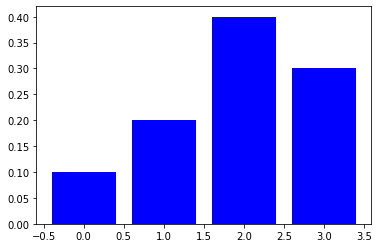

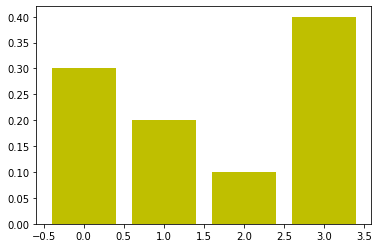

In [5]:
plt.bar(range(4), pi, color='b')
plt.show()
plt.bar(range(4), p, color='y')
plt.show()

In [6]:
transport_plan_example = pi.reshape(-1, 1) * p.reshape(1, -1)

In [7]:
transport_plan_example

array([[0.03, 0.02, 0.01, 0.04],
       [0.06, 0.04, 0.02, 0.08],
       [0.12, 0.08, 0.04, 0.16],
       [0.09, 0.06, 0.03, 0.12]])

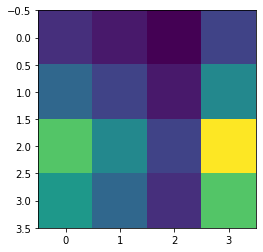

In [8]:
plt.imshow(transport_plan_example)
plt.show()

In [9]:
transport_plan_example.sum()

1.0

In [10]:
transport_plan_example.sum(axis=1)

array([0.1, 0.2, 0.4, 0.3])

In [11]:
pi

array([0.1, 0.2, 0.4, 0.3])

In [12]:
transport_plan_example.sum(axis=1)

array([0.1, 0.2, 0.4, 0.3])

In [13]:
p

array([0.3, 0.2, 0.1, 0.4])

In [14]:
cost = np.abs(np.arange(4).reshape(-1, 1) - np.arange(4).reshape(1, -1)).astype('float')

In [15]:
cost

array([[0., 1., 2., 3.],
       [1., 0., 1., 2.],
       [2., 1., 0., 1.],
       [3., 2., 1., 0.]])

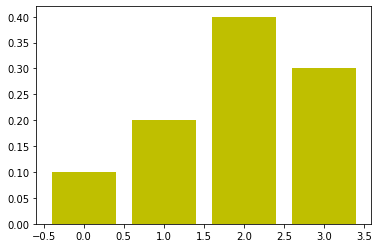

0 -> 0, how many: 0.030, cost: 0.000, total_cost: 0.000


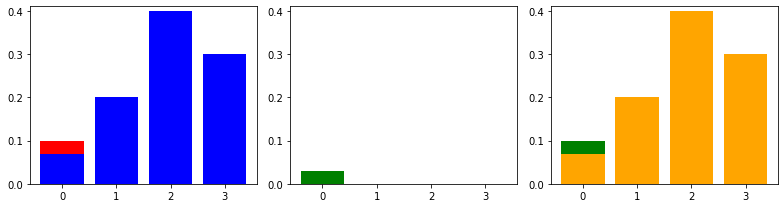

0 -> 1, how many: 0.020, cost: 0.020, total_cost: 0.020


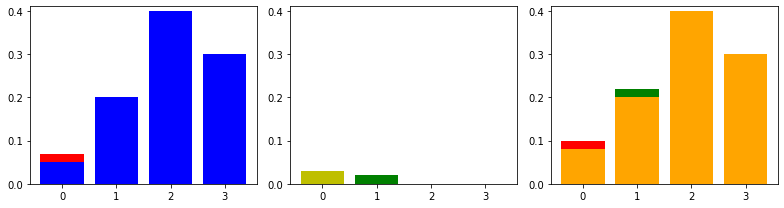

0 -> 2, how many: 0.010, cost: 0.020, total_cost: 0.040


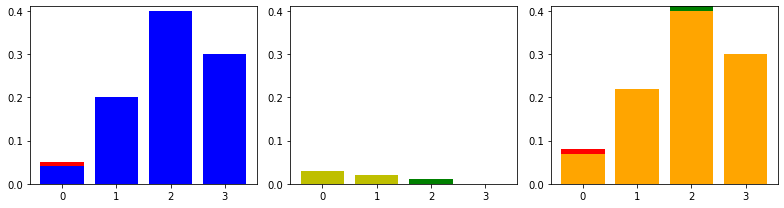

0 -> 3, how many: 0.040, cost: 0.120, total_cost: 0.160


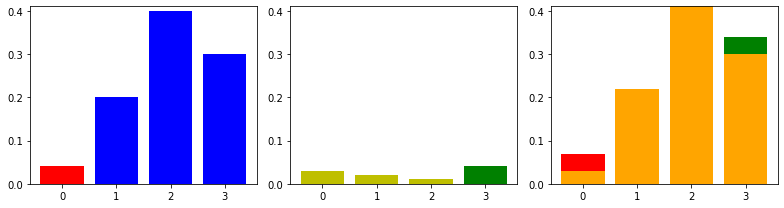

1 -> 0, how many: 0.060, cost: 0.060, total_cost: 0.220


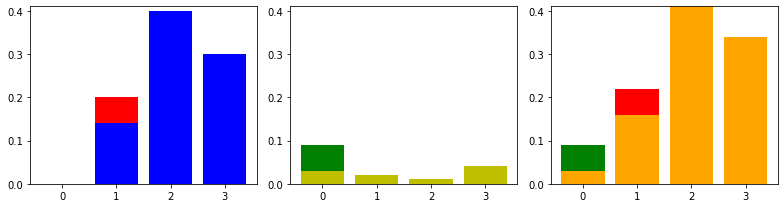

1 -> 1, how many: 0.040, cost: 0.000, total_cost: 0.220


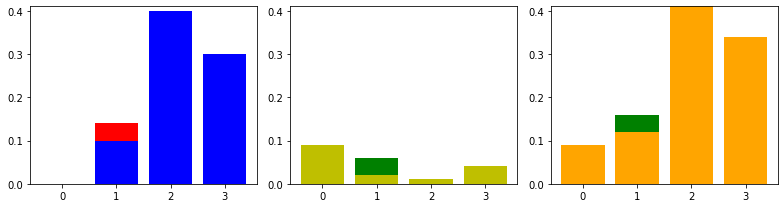

1 -> 2, how many: 0.020, cost: 0.020, total_cost: 0.240


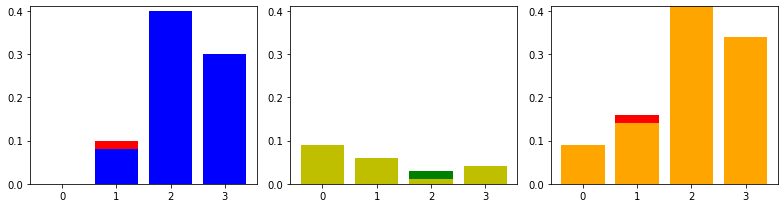

1 -> 3, how many: 0.080, cost: 0.160, total_cost: 0.400


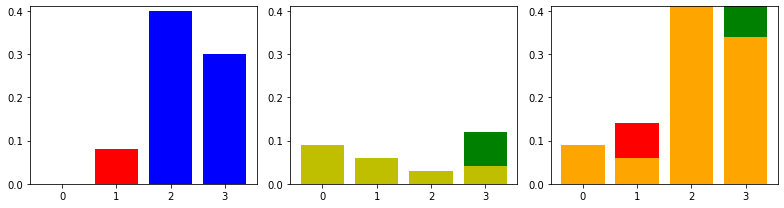

2 -> 0, how many: 0.120, cost: 0.240, total_cost: 0.640


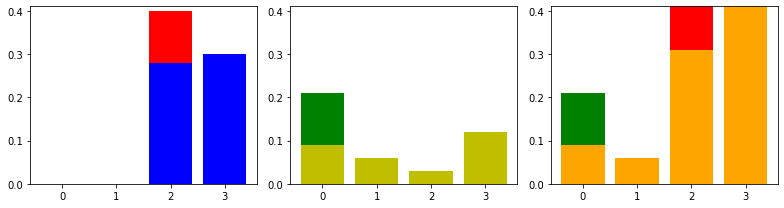

2 -> 1, how many: 0.080, cost: 0.080, total_cost: 0.720


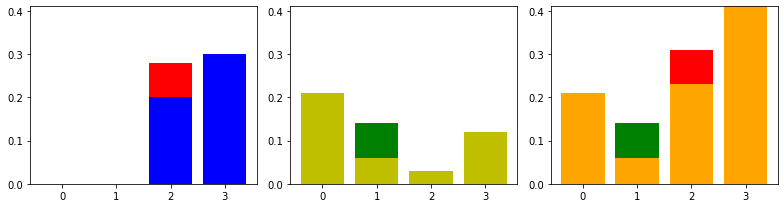

2 -> 2, how many: 0.040, cost: 0.000, total_cost: 0.720


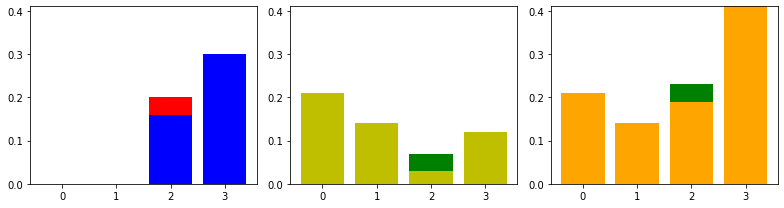

2 -> 3, how many: 0.160, cost: 0.160, total_cost: 0.880


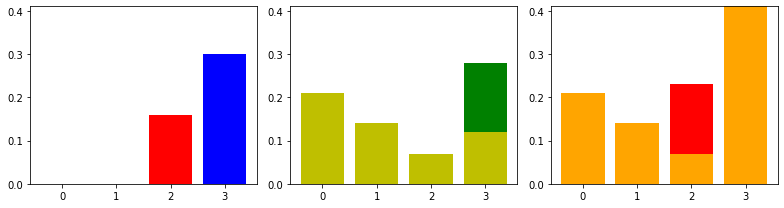

3 -> 0, how many: 0.090, cost: 0.270, total_cost: 1.150


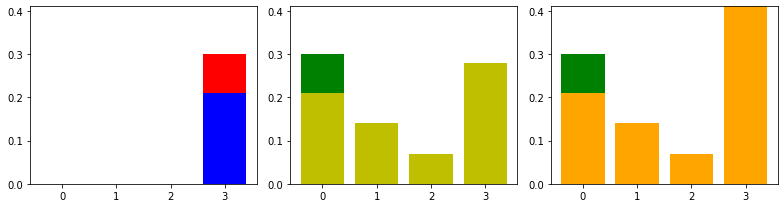

3 -> 1, how many: 0.060, cost: 0.120, total_cost: 1.270


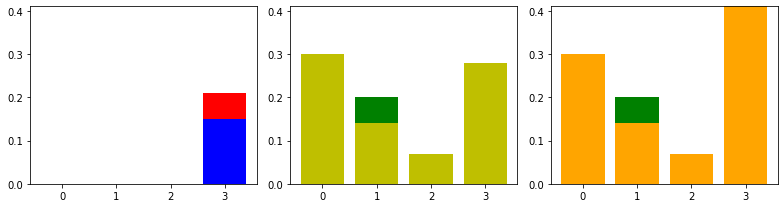

3 -> 2, how many: 0.030, cost: 0.030, total_cost: 1.300


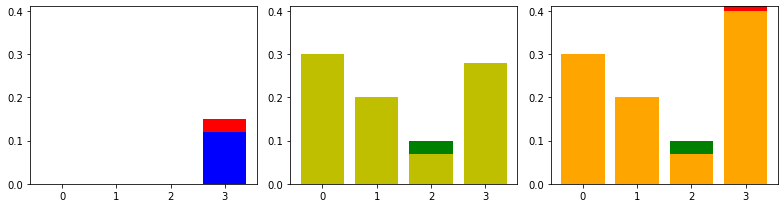

3 -> 3, how many: 0.120, cost: 0.000, total_cost: 1.300


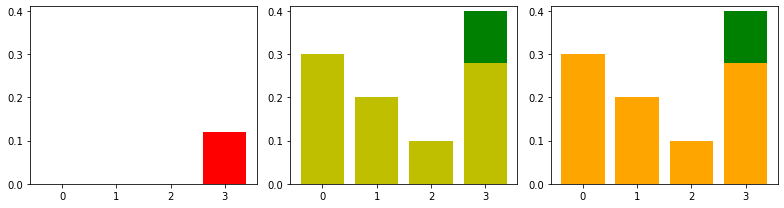

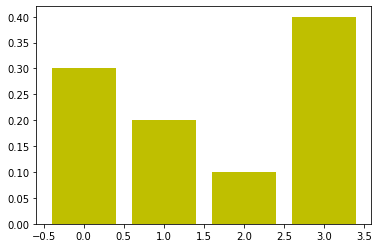

In [16]:
pi_reduction = np.zeros((17, 4))
p_building = np.zeros((17, 4))
pi_reduction[0] = pi.copy()

def draw_one_step(step):
    fig, axs = plt.subplots(1, 3, figsize=(11, 3))
    axs[0].bar(range(4), pi_reduction[step - 1], color='r')
    axs[0].bar(range(4), pi_reduction[step], color='b')
    axs[0].set_ylim(0, 0.41)
    axs[1].bar(range(4), p_building[step], color='g')
    axs[1].bar(range(4), p_building[step - 1], color='y')
    axs[1].set_ylim(0, 0.41)
    axs[2].bar(range(4), p_building[step - 1] + pi_reduction[step - 1], color='r')
    axs[2].bar(range(4), p_building[step] + pi_reduction[step], color='g')
    axs[2].bar(range(4), p_building[step - 1] + pi_reduction[step], color='orange')
    axs[2].set_ylim(0, 0.41)
    plt.tight_layout()
    plt.show()

plt.bar(range(4), pi, color='y')
plt.show()

step = 0
total_cost = 0.0
for i in range(4):
    for j in range(4):
        step += 1
        pi_reduction[step] = pi_reduction[step - 1].copy()
        pi_reduction[step][i] -= transport_plan_example[i, j]
        p_building[step] = p_building[step - 1].copy()
        p_building[step][j] += transport_plan_example[i, j]
        c = transport_plan_example[i, j] * cost[i, j]
        total_cost += c
        print('{} -> {}, how many: {:.3f}, cost: {:.3f}, total_cost: {:.3f}'.format(
            i,j, transport_plan_example[i, j], c, total_cost))
        draw_one_step(step)
        
plt.bar(range(4), p, color='y')
plt.show()

Package for discrete OT problems: [POT](https://pythonot.github.io/index.html)

In [17]:
transport_plan_optimal = ot.emd(pi, p, cost)
w_distance = ot.emd2(pi, p, cost)
print('w_distance: ', w_distance)

w_distance:  0.5


In [18]:
np.allclose(transport_plan_optimal.sum(axis=1), pi)

True

In [19]:
np.allclose(transport_plan_optimal.sum(axis=0), p)

True

In [20]:
pi

array([0.1, 0.2, 0.4, 0.3])

In [21]:
p

array([0.3, 0.2, 0.1, 0.4])

In [22]:
np.round(transport_plan_optimal, 5)

array([[0.1, 0. , 0. , 0. ],
       [0.2, 0. , 0. , 0. ],
       [0. , 0.2, 0.1, 0.1],
       [0. , 0. , 0. , 0.3]])

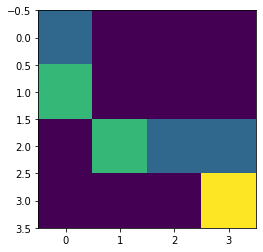

In [23]:
plt.imshow(transport_plan_optimal)
plt.show()

### Discrete optimal transport complexities

* original optimal transport problem : $O(n^3 \log(n))$

$$\gamma^* = \arg\min\limits_{\gamma \in \mathbb{R}^{n \times n}_{+}} \sum\limits_{i, j} \gamma_{i, j} \text{Cost}_{i, j}\\ \,\, \text{s.t. } \gamma 1 = \pi ; \gamma^T 1 = p$$

* (`*`) $\varepsilon$ - entropy regularized optimal transport problem: repeated iterations of Sinkhorn algorithm $O(n^2)$, convergence rate depends on $\varepsilon$

$$\gamma^*_{\varepsilon} = \arg\min\limits_{\gamma \in \mathbb{R}^{n \times n}_{+}} \sum\limits_{i, j} \gamma_{i, j} \text{Cost}_{i, j} + \varepsilon KL(\gamma | \pi \otimes p)\\ \,\, \text{s.t. } \gamma 1 = \pi ; \gamma^T 1 = p$$

Check the [video](https://www.youtube.com/watch?v=ecbbuGTj3DI) for the details.

### Continuous 1-Wasserstein distance

## Vanilla GAN,  WGAN and WGAN-GP on 2D data

In [24]:
def generate_2d_data(size, var=0.02):
    scale = 2
    centers = [
        (1, 0),
        (-1, 0),
        (0, 1),
        (0, -1),
        (1. / np.sqrt(2), 1. / np.sqrt(2)),
        (1. / np.sqrt(2), -1. / np.sqrt(2)),
        (-1. / np.sqrt(2), 1. / np.sqrt(2)),
        (-1. / np.sqrt(2), -1. / np.sqrt(2))
    ]

    centers = [(scale * x, scale * y) for x, y in centers]
    dataset = []

    for i in range(size):
        point = np.random.randn(2) * var
        center = centers[np.random.choice(np.arange(len(centers)))]
        point[0] += center[0]
        point[1] += center[1]
        dataset.append(point)

    dataset = np.array(dataset, dtype='float32')
    dataset /= 1.414  # stdev

    return dataset

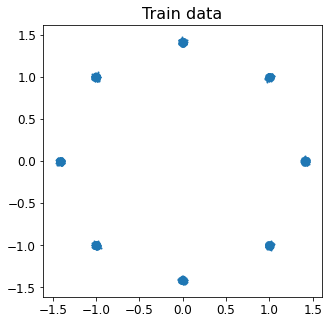

In [25]:
reset_seed()
COUNT = 20000

train_data = generate_2d_data(COUNT, var=0.02) # 0.02, 0.1, 0.4
visualize_2d_samples(train_data, "Train data")

Visualization functions

In [26]:
from seminar10_utils import batch_jacobian

def make_inference(generator, critic, n_samples=5000, compute_grad_norms=True):
    generator.eval()
    critic.eval()
    xs = np.linspace(-3.0, 3.0, 1000 + 1)
    xg, yg = np.meshgrid(xs, xs)
    grid = np.concatenate((xg.reshape(-1, 1), yg.reshape(-1, 1)), axis=-1)

    tsr_grid = torch.FloatTensor(grid).to(DEVICE)
    with torch.no_grad():
        samples = generator.sample(n_samples).cpu().detach().numpy()
        critic_output = critic(tsr_grid).cpu().detach().numpy()

    if compute_grad_norms:
        tsr_grid.requires_grad_() # (grid_size, 2)
        _critic_output = critic(tsr_grid) # (grid_size, 1)
        assert len(critic_output.shape) == 2
        grads = batch_jacobian(
            tsr_grid, _critic_output, 
            create_graph=False, retain_graph=False).squeeze(1) # (grid_size, 2)
        critic_grad_norms = torch.norm(grads, dim=-1).detach().cpu().numpy().reshape((1000 + 1, 1000 + 1))

    critic_output = np.prod(critic_output, axis=-1).reshape((1000 + 1, 1000 + 1))
    if compute_grad_norms:
        return samples, grid, critic_output, critic_grad_norms
    return samples, grid, critic_output

def visualize_GAN_output(
    generated_samples, real_samples, grid, 
    critic_output, critic_grad_norms, npts=100 + 1):

    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    # plt.figure(figsize=(6, 6))
    # plt.gca().set_aspect("equal")

    npts = critic_output.shape[0]
    cnt = ax[0].contourf(
        grid[:, 0].reshape((npts, npts)), grid[:, 1].reshape((npts, npts)), critic_output,
        levels=25, cmap="cividis"
    )
    ax[0].scatter(generated_samples[:, 0], generated_samples[:, 1], marker=".", color="red", s=0.5)
    ax[0].scatter(real_samples[:, 0], real_samples[:, 1], marker="x", color="blue", s=0.5)
    ax[0].set_title('Critic/discriminator outputs')
    fig.colorbar(cnt, ax=ax[0])
    cnt = ax[1].contourf(
        grid[:, 0].reshape((npts, npts)), grid[:, 1].reshape((npts, npts)), critic_grad_norms,
        levels=25, cmap="cividis"
    )
    ax[1].set_title('Norms of critic/discriminator gradients')
    fig.colorbar(cnt, ax=ax[1])
    plt.show()

def plot_losses(losses, title):
    n_itr = len(losses)
    xs = np.arange(n_itr)

    plt.figure(figsize=(7, 5))
    plt.plot(xs, losses)
    plt.title(title, fontsize=14)
    plt.xlabel('Iterations', fontsize=14)
    plt.ylabel('Loss', fontsize=14)

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

# Vanilla GAN

<img src="pics/gan_objective.jpg" width=800 height=800 />

In [28]:
from seminar10_utils import FullyConnectedMLP

`GAN` generator

In [29]:
class MLPGenerator(FullyConnectedMLP):

    def sample(self, n):
        z = torch.randn(size=(n, self.input_dim)).to(
            next(iter(self.parameters())))
        return self.forward(z)

`GAN` discriminator

In [30]:
class MLPDiscriminator(FullyConnectedMLP):

    def __init__(self, input_dim, hiddens, output_dim):
        super().__init__(input_dim, hiddens, output_dim)
        self._criterion = nn.BCELoss()

    def forward(self, z):
        x = super().forward(z)
        return F.sigmoid(x)

    def criterion(self, x, gt='fake'):
        assert gt in ['fake', 'real']
        tensor_gt = torch.zeros_like(x) if gt == 'fake' else torch.ones_like(x)
        return self._criterion(x, tensor_gt)

`GAN` training loop

In [31]:
def train_gan(
    generator, 
    discriminator, 
    train_loader,
    discriminator_steps, 
    batch_size,
    n_epochs,
    lr, 
    clip_c, 
    visualize_steps=10):

    gen_optimizer = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0, 0.9))
    discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0, 0.9))

    generator.train()
    discriminator.train()

    curr_iter = 0
    d_loss, g_loss = torch.zeros(1), torch.zeros(1)
    batch_loss_history = {'discriminator_losses': [], 'generator_losses': []}

    for epoch_i in tqdm(range(n_epochs)):
        for (batch_i, real_data) in enumerate(train_loader):
            curr_iter += 1
            real_data = real_data.to(DEVICE)

            # DISCRIMINATOR UPDATE
            with torch.no_grad():
                fake_data = generator.sample(real_data.shape[0])

            pred_real = discriminator(real_data)
            loss_real = discriminator.criterion(pred_real, 'real')
            pred_fake = discriminator(fake_data)
            loss_fake = discriminator.criterion(pred_fake, 'fake')

            discriminator_optimizer.zero_grad()
            d_loss = (loss_real + loss_fake) / 2.
            d_loss.backward()
            discriminator_optimizer.step()

            # GENERATOR UPDATE
            if curr_iter % discriminator_steps == 0:
                gen_optimizer.zero_grad()
                fake_data = generator.sample(batch_size)
                pred_fake = discriminator(fake_data).mean()
                g_loss = discriminator.criterion(pred_fake, 'real')
                g_loss.backward()
                gen_optimizer.step()

                batch_loss_history['generator_losses'].append(g_loss.data.cpu().numpy())
                batch_loss_history['discriminator_losses'].append(d_loss.data.cpu().numpy())

        if visualize_steps and epoch_i % visualize_steps == 0:
            print('Epoch {}'.format(epoch_i))
            samples, grid, discr_output, discr_grad_norms = make_inference(generator, discriminator)
            visualize_GAN_output(samples, train_data, grid, discr_output, discr_grad_norms)

    return batch_loss_history

`GAN` training

In [36]:
reset_seed()
BATCH_SIZE = 1024 # any adequate value
GEN_HIDDENS = [32, 128, 128, 32] # 4 layers with < 128 neurons would be enough
DISCR_HIDDENS = [64, 256, 256, 64] # 4 layers with < 128 neurons would be enough
CRITIC_STEPS = 5 # > 2
LR = 2e-4 # < 1e-2
CLIP_C = 0.05 # < 1

N_EPOCHS = 100 # change it if you want

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

generator = MLPGenerator(16, GEN_HIDDENS, 2).to(DEVICE)
discriminator = MLPDiscriminator(2, DISCR_HIDDENS, 1).to(DEVICE)

train_losses = train_gan(
    generator, 
    discriminator, 
    train_loader,
    discriminator_steps=CRITIC_STEPS, 
    batch_size=BATCH_SIZE, 
    n_epochs=N_EPOCHS,
    lr=LR,
    clip_c=CLIP_C,
    visualize_steps=20
)

plot_losses(train_losses['discriminator_losses'], 'Critic loss')
plot_losses(train_losses['generator_losses'], 'Generator loss')

In [35]:
samples, grid, discr_output, discr_grad_norms = make_inference(generator, discriminator)
visualize_GAN_output(samples, train_data, grid, discr_output, discr_grad_norms)

## WGAN

[WGAN](https://arxiv.org/abs/1701.07875) model uses weight clipping to enforce Lipschitzness of the critic.

The model objective is
$$
\min_{G} W(\pi || p) \approx \min_{G} \max_{\boldsymbol{\phi} \in \boldsymbol{\Phi}} \left[ \mathbb{E}_{\pi(\mathbf{x})} f(\mathbf{x}, \boldsymbol{\phi})  - \mathbb{E}_{p(\mathbf{z})} f(G(\mathbf{z}, \boldsymbol{\theta}), \boldsymbol{\phi} )\right].
$$
Here $f(\mathbf{x}, \boldsymbol{\phi})$ is the critic model. The critic weights $\boldsymbol{\phi}$ should lie in the compact set $\boldsymbol{\Phi} = [-c, c]^d$.

<img src="pics/wgan_alg.jpg" width=800 height=800 />

In [37]:
from seminar10_utils import FullyConnectedMLP

`WGAN` generator model

In [38]:
class MLPGenerator(FullyConnectedMLP):

    def sample(self, n):
        z = torch.randn(size=(n, self.input_dim)).to(
            next(iter(self.parameters())))
        return self.forward(z)

`WGAN` discriminator model

In [39]:
class MLPCritic(FullyConnectedMLP):

    def clip_weights(self, c):
        for layer in self.net:
            if isinstance(layer, nn.Linear):
                layer.weight.data = torch.clamp(layer.weight.data, -c, c)
                layer.bias.data = torch.clamp(layer.bias.data, -c, c)

`WGAN` train loop

In [40]:
def train_wgan(
    generator, 
    critic, 
    train_loader,
    critic_steps, 
    batch_size,
    n_epochs,
    lr, 
    clip_c, 
    visualize_steps=10):

    gen_optimizer = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0, 0.9))
    critic_optimizer = torch.optim.Adam(critic.parameters(), lr=lr, betas=(0, 0.9))

    generator.train()
    critic.train()

    curr_iter = 0
    d_loss, g_loss = torch.zeros(1), torch.zeros(1)
    batch_loss_history = {'discriminator_losses': [], 'generator_losses': []}

    for epoch_i in tqdm(range(n_epochs)):
        for (batch_i, x) in enumerate(train_loader):
            curr_iter += 1
            x = x.to(DEVICE)

            # CRITIC UPDATE
            with torch.no_grad():
                fake_data = generator.sample(x.shape[0])

            critic_optimizer.zero_grad()
            d_loss = (critic(fake_data) - critic(x)).mean()
            d_loss.backward()
            critic_optimizer.step()
            critic.clip_weights(clip_c)

            # GENERATOR UPDATE
            if curr_iter % critic_steps == 0:
                gen_optimizer.zero_grad()
                fake_data = generator.sample(batch_size)
                g_loss = -critic(fake_data).mean()
                g_loss.backward()
                gen_optimizer.step()

                batch_loss_history['generator_losses'].append(g_loss.data.cpu().numpy())
                batch_loss_history['discriminator_losses'].append(d_loss.data.cpu().numpy())
        if visualize_steps and epoch_i % visualize_steps == 0:
            print('Epoch {}'.format(epoch_i))
            samples, grid, critic_output, critic_grad_norms = make_inference(generator, critic)
            visualize_GAN_output(samples, train_data, grid, critic_output, critic_grad_norms)

    return batch_loss_history

Playing with `WGAN`

In [42]:
reset_seed()
BATCH_SIZE = 1024 # any adequate value
GEN_HIDDENS = [32, 128, 128, 32] # 4 layers with < 128 neurons would be enough
DISCR_HIDDENS = [64, 256, 256, 64] # 4 layers with < 128 neurons would be enough
CRITIC_STEPS = 5 # > 2
LR = 2e-4 # < 1e-2
CLIP_C = 0.05 # < 1

N_EPOCHS = 10 # change it if you want

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

generator = MLPGenerator(16, GEN_HIDDENS, 2).to(DEVICE)
critic = MLPCritic(2, DISCR_HIDDENS, 1).to(DEVICE)

train_losses = train_wgan(
    generator, 
    critic, 
    train_loader,
    critic_steps=CRITIC_STEPS, 
    batch_size=BATCH_SIZE, 
    n_epochs=N_EPOCHS,
    lr=LR,
    clip_c=CLIP_C,
    visualize_steps=1
)

plot_losses(train_losses['discriminator_losses'], 'Critic loss')
plot_losses(train_losses['generator_losses'], 'Generator loss')

`WGAN` training

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 0


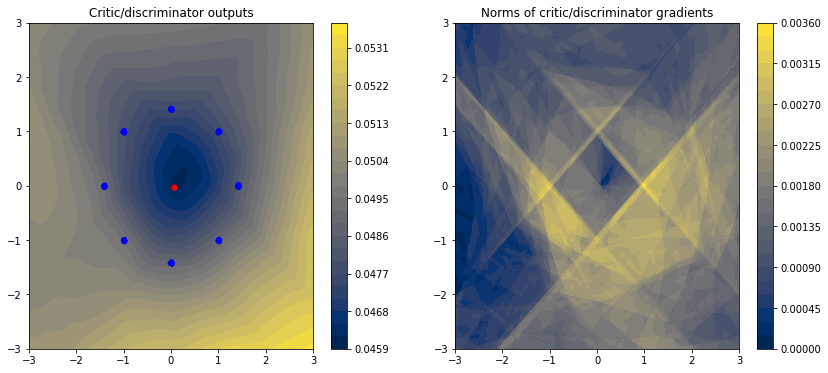

Epoch 50


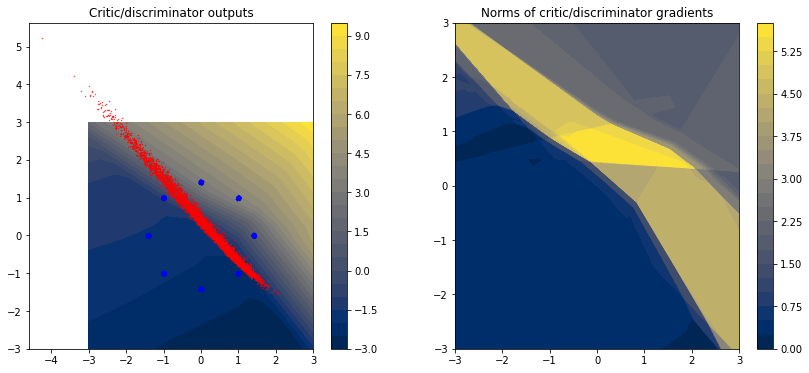

Epoch 100


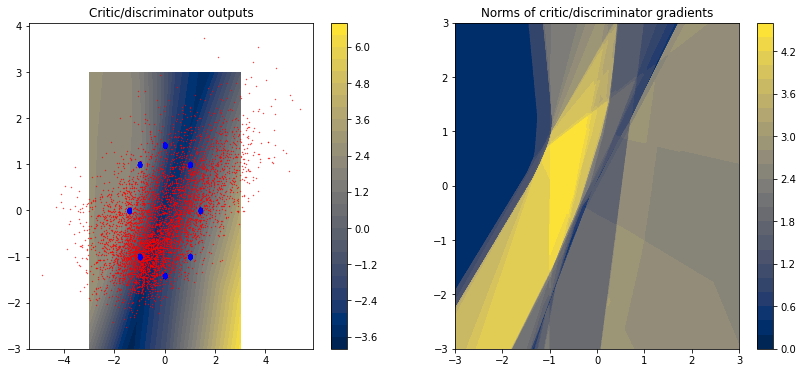

Epoch 150


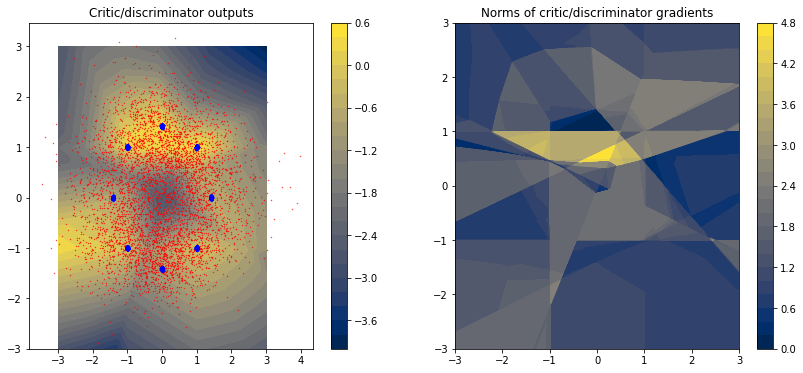

Epoch 200


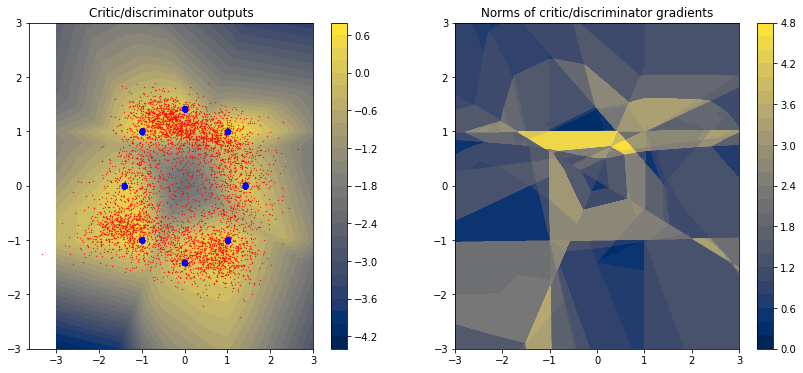

Epoch 250


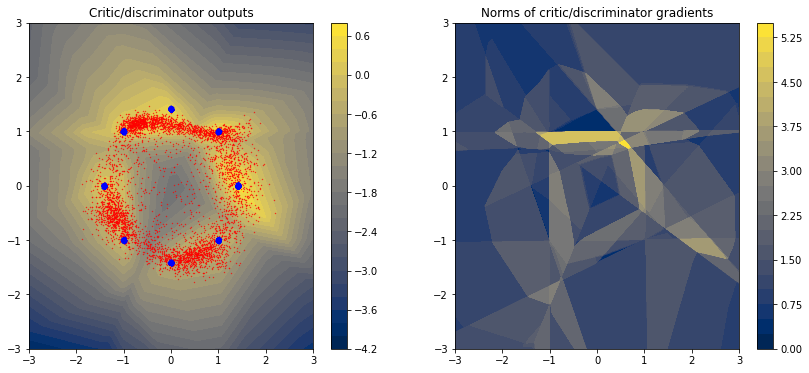

Epoch 300


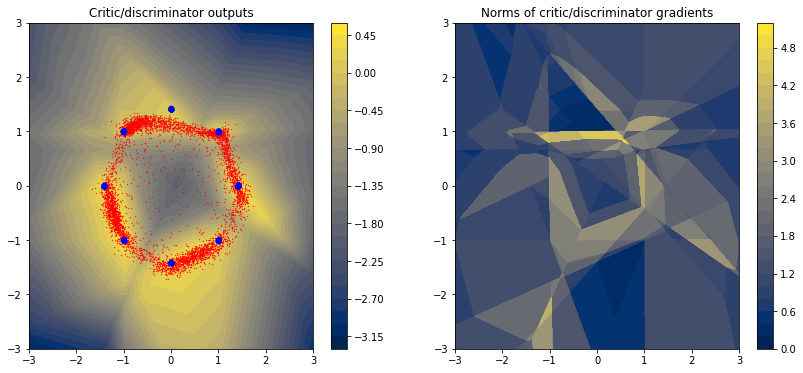

Epoch 350


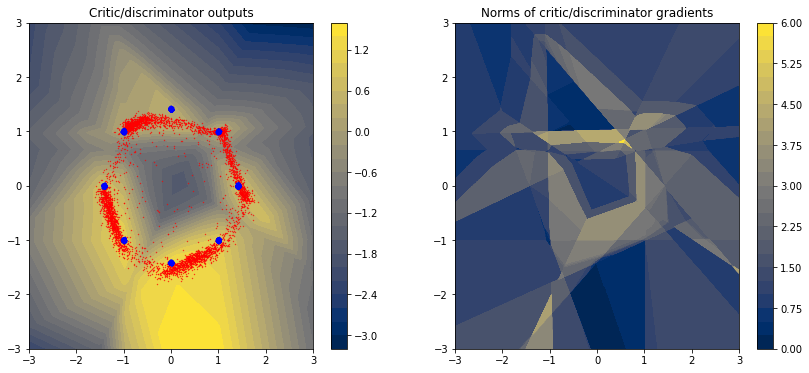

Epoch 400


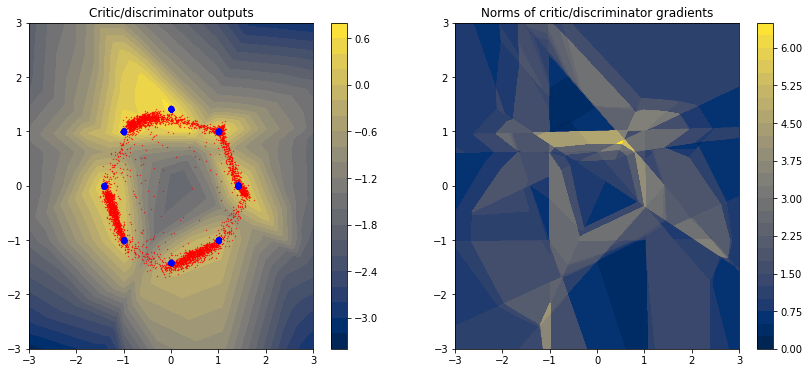

Epoch 450


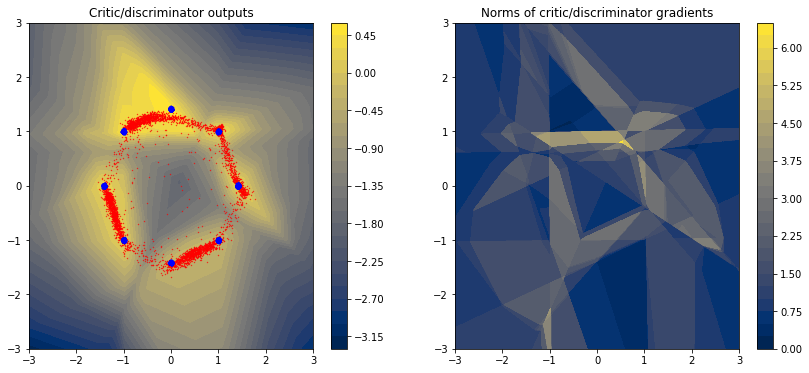

Epoch 500


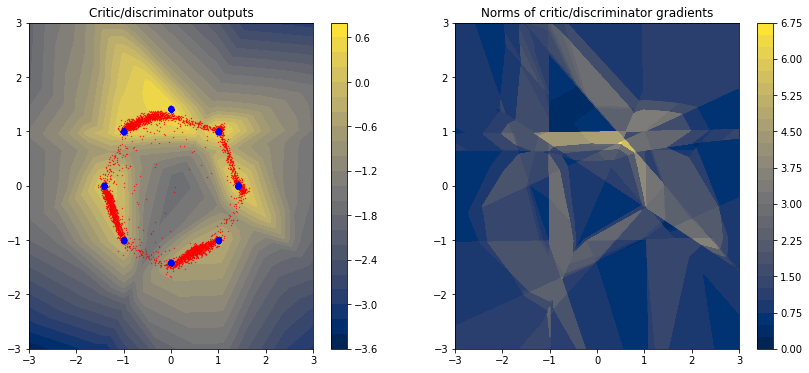

Epoch 550


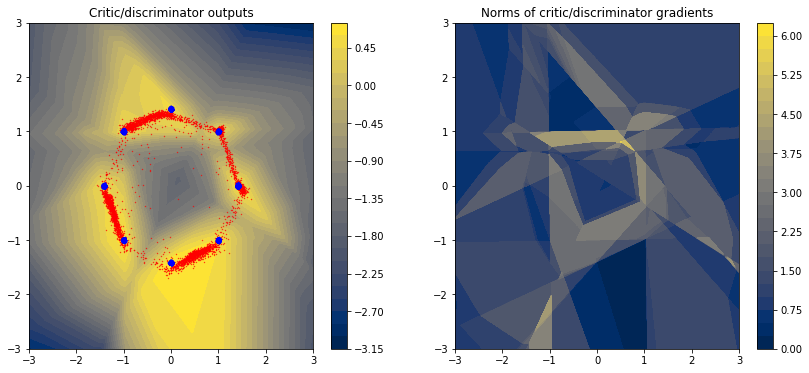

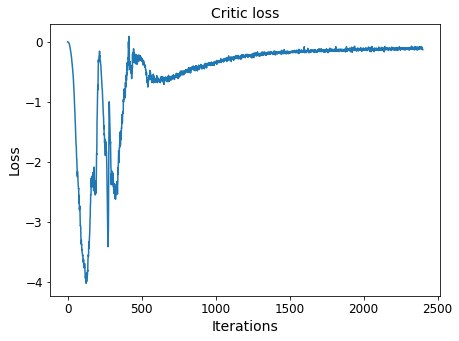

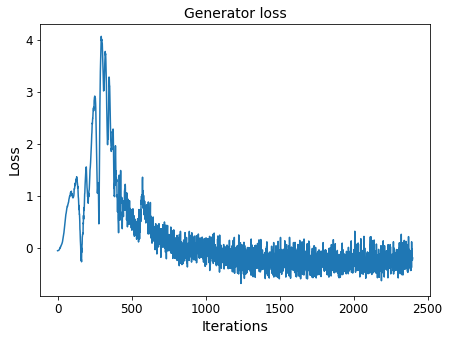

In [17]:
reset_seed()
BATCH_SIZE = 1024 # any adequate value
GEN_HIDDENS = [32, 128, 128, 32] # 4 layers with < 128 neurons would be enough
DISCR_HIDDENS = [64, 256, 256, 64] # 4 layers with < 128 neurons would be enough
CRITIC_STEPS = 5 # > 2
LR = 2e-4 # < 1e-2
CLIP_C = 0.05 # < 1

N_EPOCHS = 600 # change it if you want

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

generator = MLPGenerator(16, GEN_HIDDENS, 2).to(DEVICE)
critic = MLPCritic(2, DISCR_HIDDENS, 1).to(DEVICE)

train_losses = train_wgan(
    generator, 
    critic, 
    train_loader,
    critic_steps=CRITIC_STEPS, 
    batch_size=BATCH_SIZE, 
    n_epochs=N_EPOCHS,
    lr=LR,
    clip_c=CLIP_C,
    visualize_steps=50
)

plot_losses(train_losses['discriminator_losses'], 'Critic loss')
plot_losses(train_losses['generator_losses'], 'Generator loss')

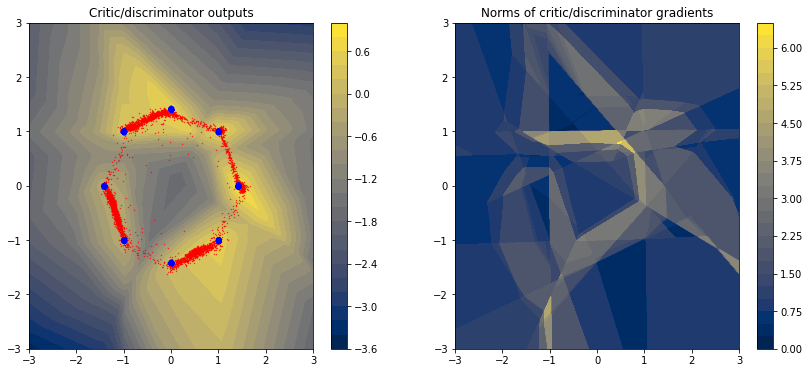

In [18]:
samples, grid, critic_output, critic_grad_norms = make_inference(generator, critic)
visualize_GAN_output(samples, train_data, grid, critic_output, critic_grad_norms)

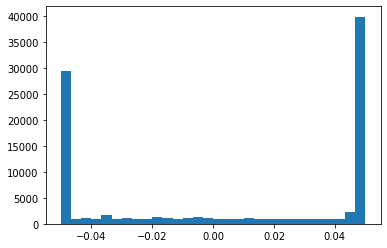

In [19]:
params = []
for param in critic.parameters():
    params.extend(param.detach().cpu().numpy().flatten())
plt.hist(params, bins=30)
plt.show()

## WGAN-GP

[WGAN-GP](https://arxiv.org/pdf/1704.00028.pdf)  model uses gradient penalty to enforce Lipschitzness.

The model objective is
$$
    W(\pi || p) = \underbrace{\mathbb{E}_{\pi(\mathbf{x})} f(\mathbf{x})  - \mathbb{E}_{p(\mathbf{x} | \boldsymbol{\theta})} f(\mathbf{x})}_{\text{original critic loss}} + \lambda \underbrace{\mathbb{E}_{U[0, 1]} \left[ \left( \| \nabla_{\hat{\mathbf{x}}} f(\hat{\mathbf{x}}) \|_2 - 1 \right) ^ 2\right]}_{\text{gradient penalty}},
$$
where the samples $\hat{\mathbf{x}}_t = t \mathbf{x} + (1 - t) \mathbf{y}$ with $t \in [0, 1]$ are uniformly sampled along straight lines between pairs of points: $\mathbf{x}$ from the data distribution $\pi(\mathbf{x})$ and $\mathbf{y}$ from the generator distribution $p(\mathbf{x} | \boldsymbol{\theta}))$.

<img src="pics/WGAN-GP_theorem.jpg" width=800 height=800 />

<img src="pics/wgan-gp_alg.jpg" width=800 height=800 />

In [43]:
from wgan_gp import train_wgan_gp

Playing with `WGAN-GP`

In [45]:
reset_seed()
BATCH_SIZE = 1024 # any adequate value
GEN_HIDDENS = [32, 128, 128, 32] # 4 layers with < 128 neurons would be enough
DISCR_HIDDENS = [64, 256, 256, 64] # 4 layers with < 128 neurons would be enough
CRITIC_STEPS = 5 # > 2
LR = 2e-4 # < 1e-2
GP_WEIGHT = 10 # > 5

N_EPOCHS = 10 # change it if you want

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

generator = MLPGenerator(16, GEN_HIDDENS, 2).to(DEVICE)
critic = MLPCritic(2, DISCR_HIDDENS, 1).to(DEVICE)

train_losses = train_wgan_gp(
    generator, 
    critic, 
    train_loader,
    critic_steps=CRITIC_STEPS, 
    batch_size=BATCH_SIZE, 
    n_epochs=N_EPOCHS,
    lr=LR,
    gp_weight=GP_WEIGHT,
    visualize_steps=1
)

plot_losses(train_losses['discriminator_losses'], 'Critic loss')
plot_losses(train_losses['generator_losses'], 'Generator loss')

`WGAN-GP` training

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 0


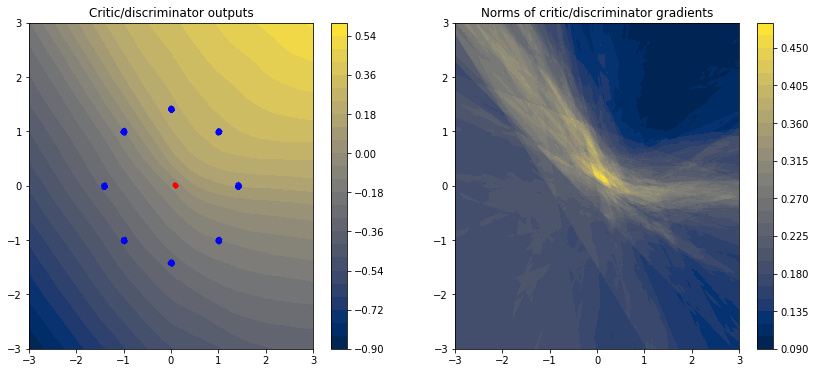

Epoch 50


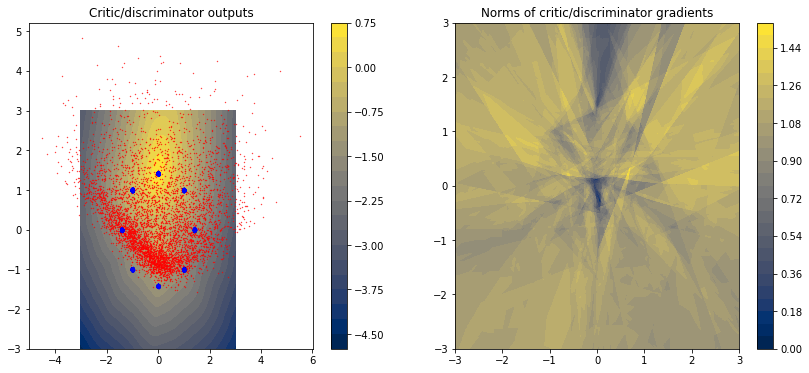

Epoch 100


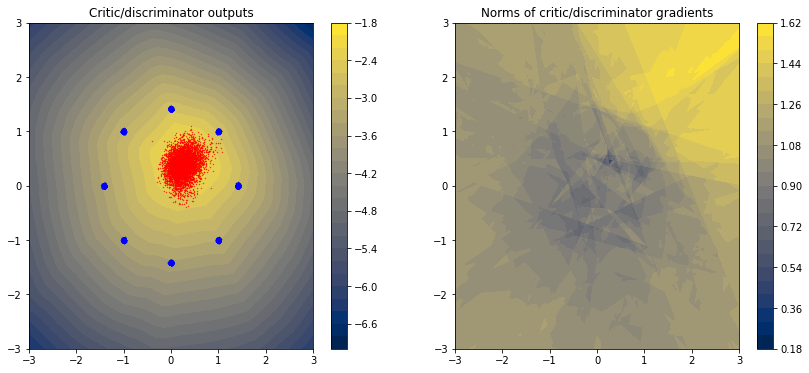

Epoch 150


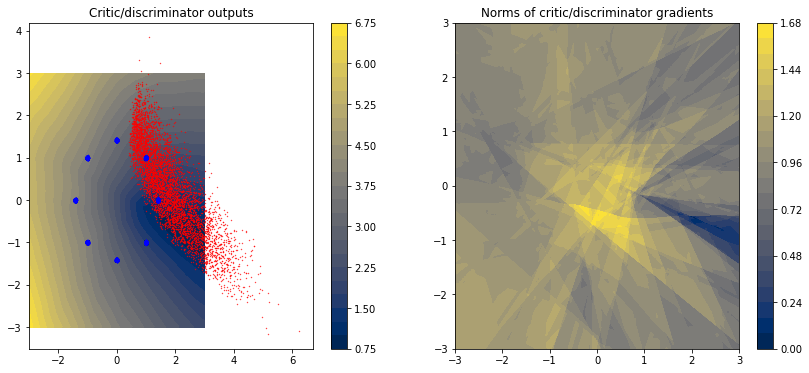

Epoch 200


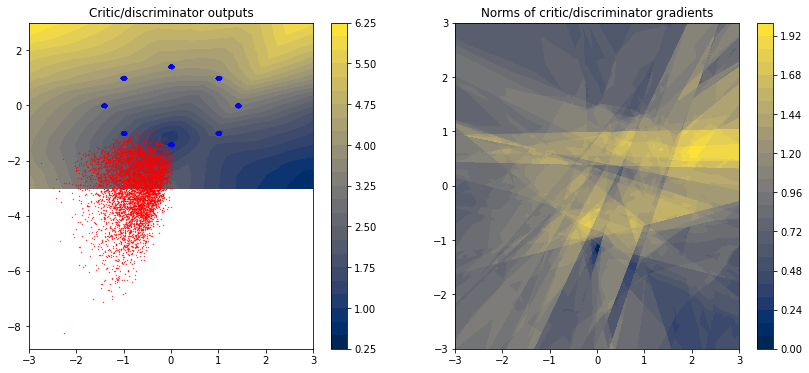

Epoch 250


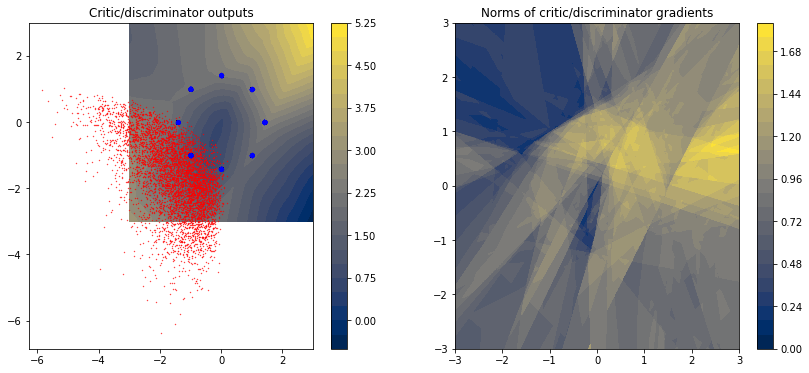

Epoch 300


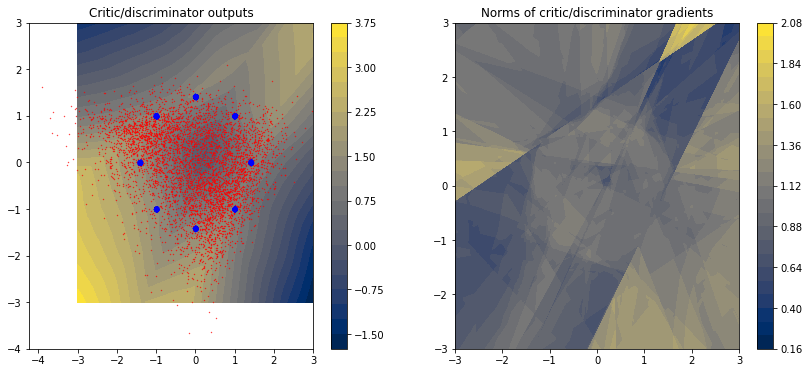

Epoch 350


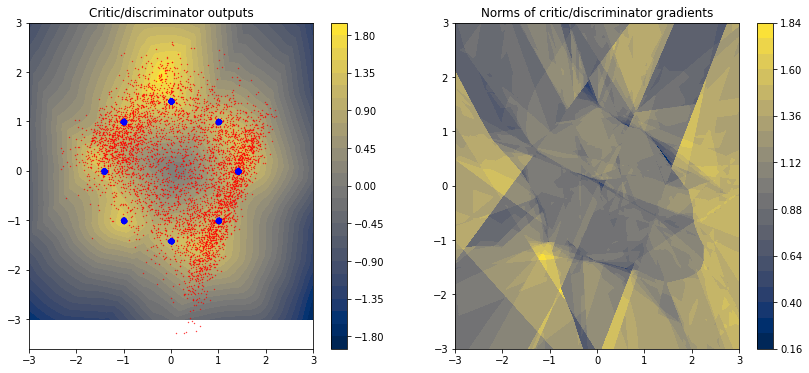

Epoch 400


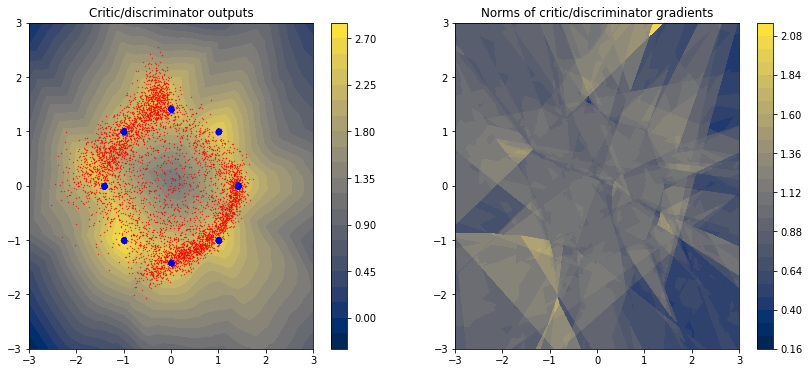

Epoch 450


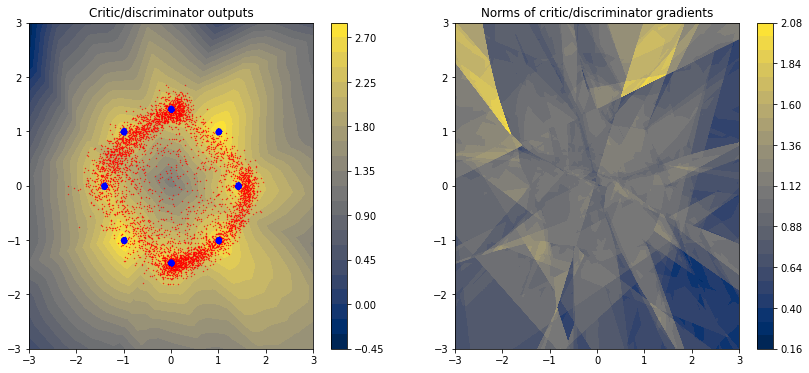

Epoch 500


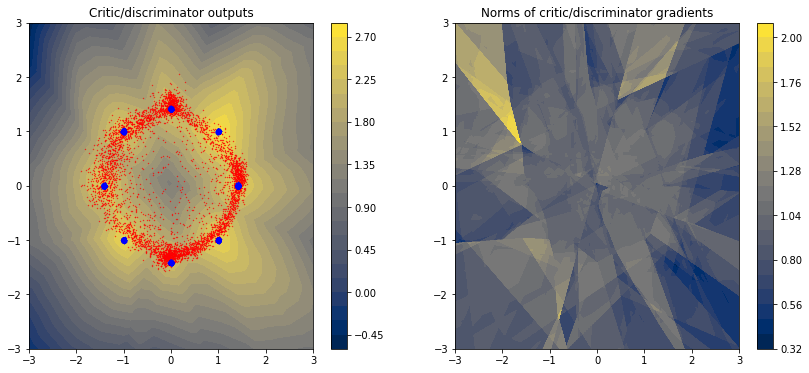

Epoch 550


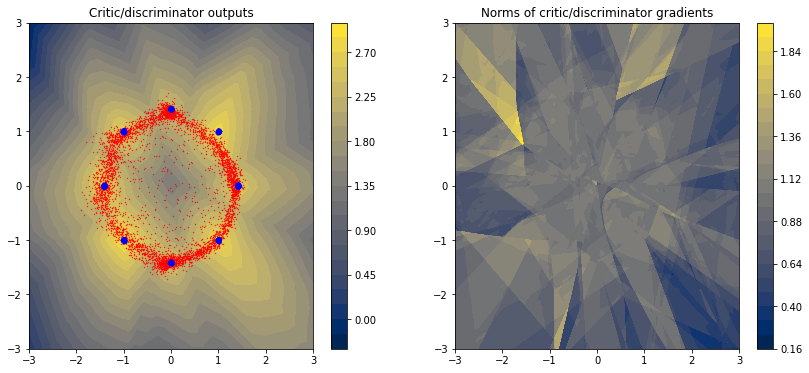

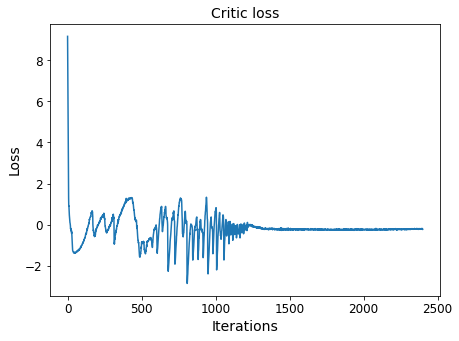

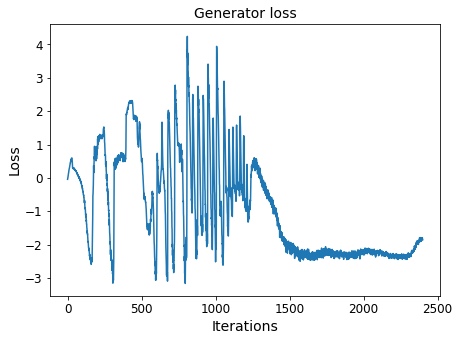

In [40]:
reset_seed()
BATCH_SIZE = 1024 # any adequate value
GEN_HIDDENS = [32, 128, 128, 32] # 4 layers with < 128 neurons would be enough
DISCR_HIDDENS = [64, 256, 256, 64] # 4 layers with < 128 neurons would be enough
CRITIC_STEPS = 5 # > 2
LR = 2e-4 # < 1e-2
GP_WEIGHT = 10 # > 5

N_EPOCHS = 600 # change it if you want

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

generator = MLPGenerator(16, GEN_HIDDENS, 2).to(DEVICE)
critic = MLPCritic(2, DISCR_HIDDENS, 1).to(DEVICE)

train_losses = train_wgan_gp(
    generator, 
    critic, 
    train_loader,
    critic_steps=CRITIC_STEPS, 
    batch_size=BATCH_SIZE, 
    n_epochs=N_EPOCHS,
    lr=LR,
    gp_weight=GP_WEIGHT,
    visualize_steps=50
)

plot_losses(train_losses['discriminator_losses'], 'Critic loss')
plot_losses(train_losses['generator_losses'], 'Generator loss')

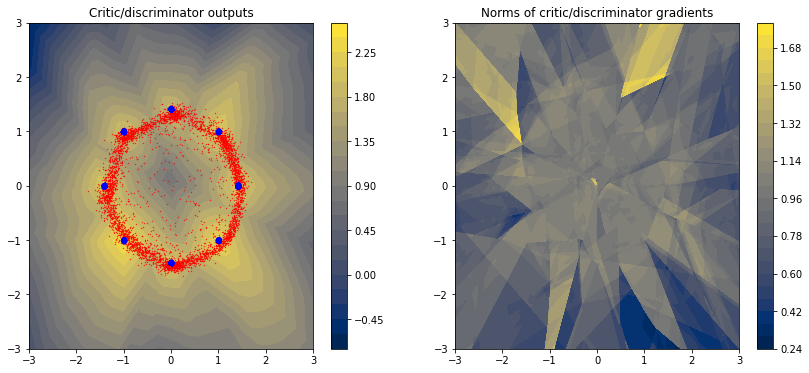

In [41]:
samples, grid, critic_output, critic_grad_norms = make_inference(generator, critic)
visualize_GAN_output(samples, train_data, grid, critic_output, critic_grad_norms)

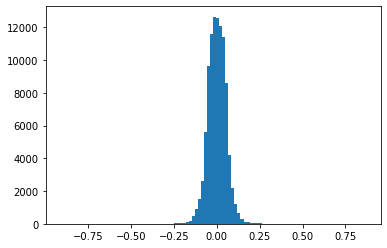

In [42]:
params = []
for param in critic.parameters():
    params.extend(param.detach().cpu().numpy().flatten())
plt.hist(params, bins=100)
plt.show()